# 

In [1]:
import comet_ml
from comet_ml.api import Parameter
COMET_KEY = 'w4JbvdIWlas52xdwict9MwmyH'
COMET_WORKSPACE = 'alainray'
api = comet_ml.api.API(api_key=COMET_KEY)
experiments = api.get(COMET_WORKSPACE, project_name='spur')
#experiments = [exp for exp in experiments if 'selected' in exp.get_tags()]

In [44]:
# For filtering experiments
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from os.path import join

def save_subplots(axs, root="",name=""):
    for i in range(len(axs)):
        for j in range(len(axs[i])):
            filename = join(root,f"{name}_{i}_{j}.png")
            extent = axs[i, j].get_window_extent().transformed(fig.dpi_scale_trans.inverted())

            axs[i, j].get_figure().savefig(filename,bbox_inches=extent.expanded(1.1, 1.2))
            
# Assumes input is list of lists
def plot_line_data(xvals, means, stds, captions=[], title="",ylabel='Accuracy (%)'):

    # Create a plot with the line chart and shaded area
    fig, ax = plt.subplots()

    for x, y, std,c in zip(xvals, means, stds,captions):
        ax.plot(x, y,label=c)
        ax.fill_between(x, y - std, y + std, alpha=0.2)

    # Add labels and title
    ax.set_xlabel('Iteration')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()

    # Show the plot
    #plt.show()
    return fig
    
def get_all_steps(r):
    data = defaultdict(list)
    for k, v in r.items():
        print(k,v)
        data[v[1]].append(v[0])
    return data

def mean_exps(exps, metrics=["acc"]): # exps: list of APIExperiment
    results = {m: [] for m in metrics}
    for exp in exps:
        for m in metrics:
            results[m].append(get_metric(exp,m))
            #print(get_metric(exp,m))
    
    data = defaultdict(list)
    for metric, values in results.items():
        for seed_values in values:
            for seed_val, step_val in seed_values:
                data[step_val].append(float(seed_val))
    x = list(data.keys())
    means = np.array([np.mean(v) for k, v in data.items()])
    stds = np.array([np.std(v) for k, v in data.items()])
    
    return x, means, stds

def mean_exps1(exps, metrics=["acc"]):
    results = {m: [] for m in metrics}
    for exp in exps:
        for m in metrics:
            results[m].append(get_metric(exp, m))

    data = defaultdict(list)
    for metric, values in results.items():
        for seed_values in values:
            # unpack seed_values into separate arrays of step_values and seed_values
            step_values, seed_values = zip(*seed_values)
            # append seed_values to the corresponding step_values in the data dictionary
            data.update({step_val: data[step_val] + [seed_val] for step_val, seed_val in zip(step_values, seed_values)})

    # compute means and standard deviations for each step value
    x = sorted(data.keys())
    means = np.array([np.mean(data[k]) for k in x])
    stds = np.array([np.std(data[k]) for k in x])
    
    return x, means, stds

def filter_experiments(exps, params):
    l = []
    for exp in exps:
        if check_params(exp, params):
            l.append(exp)
    return l

def check_params(exp, params):
    names = [p[0] for p in params] # parameter names to filter
    for p in exp.get_parameters_summary():
        
        for param in params: # Check to see if parameter exists, if it doesn't, filter out experiment    
            # Check if any of the values matches
            #print(p['name'], param[0])
            if p['name'] == param[0]:
             #   print("HOLA")
                if p['valueCurrent'] not in param[1]:
                    return False
            
    return True

def group_experiments(experiments, column): # Groups experiments over 1 column, returns a dict with values of column as key
    result = defaultdict(list)
    for exp in experiments:
        params = exp.get_parameters_summary()
        for param in params:
            if param['name'] == column:
                result[param['valueCurrent']].append(exp)                                                   
    return result

def get_metric(exp, m):
    mode = 'play' if 'play' in m else 'train'
    results = []
    for l in exp.get_metrics():
        if l['metricName'] == m:
            #print(l)
            results.append((l['metricValue'],l['step'] if mode == 'play' else l['epoch']))
            
    return results

def get_parameter_value(exp, p):
    for l in exp.get_parameters_summary():
        if l['name'] == p:
            #print(l)
            return(l['valueCurrent'])
    return -1

def pack_results(r):
    xvals = []
    means = []
    stds = []
    captions = []
    for k,(x,m,s) in r.items():
        xvals.append(x)
        means.append(m)
        stds.append(s)
        captions.append(k)
        
    return xvals, means, stds, captions

def plot_metric(exps, metrics=['acc'], title=""):
    # Select metric
    r = dict()
    for k in E.keys():
        r[k] = mean_exps(E[k], metrics)
    plot_line_data(*pack_results(r), title=title)
    
def process_data(exps,metrics=['acc']):
    r = dict()
    for k in E.keys():
        r[k] = mean_exps(E[k], metrics)

    return pack_results(r)


def create_table(trainData, testData, plot_captions=None):
    table = defaultdict(dict)
    iters = trainData[0]
    trData = trainData[1]
        
    if plot_captions == 'corr':
        corr = [2*float(p) - 1 for p in trainData[-1]]
    elif plot_captions == 'pretrained':
        corr = [2*float(float(p.split("_")[2])) - 1 for p in trainData[-1]]
    else:
        corr = [p for p in trainData[-1]]
    tsData = testData[1]

    for its, c, tr, ts  in zip(iters, corr, trData, tsData):
        table[c]['train'] = np.max(tr)
        table[c]['test'] = np.max(ts)
        table[c]['delta'] = table[c]['train'] - table[c]['test']
        timeTo = np.argwhere(tr > 90)
        timeTo = int(timeTo[0]) if len(timeTo) > 0 else -1
        table[c]['time to 90% - train'] = its[timeTo]- 1
        timeTo = np.argwhere(ts > 90)
        timeTo = int(timeTo[0]) if len(timeTo) > 0 else -1
        table[c]['time to 90% - test'] = its[timeTo]- 1
        table[c]['slowdown'] = 100*(table[c]['time to 90% - test']-table[c]['time to 90% - train'])/float(table[c]['time to 90% - train'])

    return pd.DataFrame.from_dict(table, orient='index')

# Baseline Behaviour

|  | NO BG | GRADIENT | IMAGES |
| --- | --- | --- | --- |

| Corr    |Train|Val|Test|Train|Val|Test|Train|Val|Test|
| ---|---|---|---|---|---|---|---|---|---|
|0   |Train|Val|Test|Train|Val|Test|Train|Val|Test|
|0.25|Train|Val|Test|Train|Val|Test|Train|Val|Test|
|0.5|Train|Val|Test|Train|Val|Test|Train|Val|Test|
|0.75|Train|Val|Test|Train|Val|Test|Train|Val|Test|
|0.9|Train|Val|Test|Train|Val|Test|Train|Val|Test|
|1|Train|Val|Test|Train|Val|Test|Train|Val|Test|

## 0. Performance of Baseline Models in all environments

In [3]:
envs = ['nobg','gradient','images']
#envs = ['nobg','nobg','nobg']
splits = ['train','val','test']
dfs = dict()

### 0.a) Trained on MNIST_CIFAR

In [47]:
#n_envs = len(envs)
splits = ['train','val','test']
n_splits = len(splits)

# get data first
all_data = defaultdict(dict)

experiments = api.query(COMET_WORKSPACE, 'spur', 
                  (Parameter('model') == 'scnn')
                  & (Parameter('task_dataset_name') == 'mnistcifar')
                  & (Parameter('output_dims') == "1") 
                  #& (Parameter('play_dataset') == 'cmnist')
              #    & (Parameter('load_pretrained') == 'false')
              #    & (Parameter('frozen_features') == 'false') 
              #    & (Parameter('task_dataset_baseline') == 'false')
              #    & (Parameter('task_dataset_bg') == env) 
                   )

E = group_experiments(experiments, 'task_dataset_corr')
print(len(experiments))

for m in ['acc','loss']:
    all_data['train'][m] = process_data(E, [f'task_train_{m}'])
    all_data['val'][m] = process_data(E, [f'task_val_{m}'])
    all_data['test'][m] = process_data(E, [f'eval_val_{m}'])

6


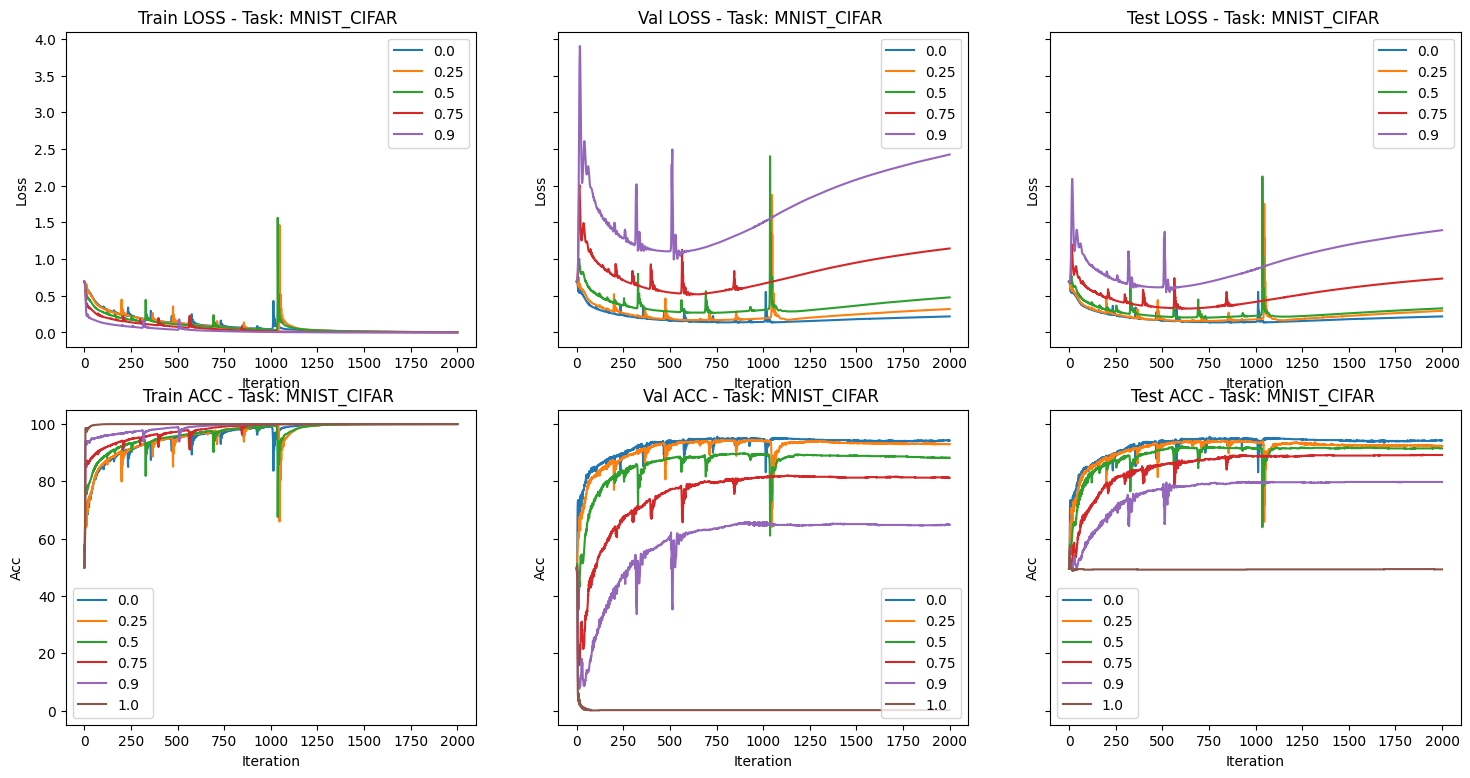

In [48]:
fig, axs = plt.subplots(2, n_splits,figsize=(18, 3*n_splits), constrained_layout=False, sharey="row")

# plot data

for i, m in enumerate(['loss','acc']):
    ylabel = m.capitalize()
    for j, split in enumerate(splits):
        data = all_data[split][m]
        xvals = data[0]
        means = data[1]
        stds = data[2]
        captions = [k for k in data[-1]]

        for x, y, std,c in zip(xvals, means, stds,captions):

            if not(m=="loss" and c == "1.0"):

                axs[i,j].plot(x, y,label=c)
                axs[i,j].fill_between(x, y - std, y + std, alpha=0.2)

        # Add labels and title
        axs[i,j].set_xlabel('Iteration')
        axs[i,j].set_ylabel(ylabel)
        axs[i,j].set_title(f"{split.capitalize()} {m.upper()} - Task: MNIST_CIFAR ")
        axs[i,j].legend()

# Save each subplot as a separate PNG file
save_subplots(axs, "imgs", "mnistcifar_binary")

In [32]:
df = create_table(all_data['train']['acc'], all_data['test']['acc']).sort_index()
df.sort_index()
df = df.style.format({'train': '{:,.1f}%'.format,
                      'test': '{:,.1f}%'.format,
                      'delta': '{:,.1f}%'.format,
                      'slowdown': '{:,.1f}%'.format})

display(HTML(df.to_html()))

,train,test,delta,time to 90% - train,time to 90% - test,slowdown
0.0,100.0%,95.6%,4.4%,196,254,29.6%
0.25,100.0%,94.3%,5.7%,182,270,48.4%
0.5,100.0%,92.3%,7.7%,132,411,211.4%
0.75,100.0%,89.3%,10.7%,66,1999,"2,928.8%"
0.9,100.0%,79.9%,20.1%,5,1999,"39,880.0%"
1.0,100.0%,55.9%,44.1%,4,1999,"49,875.0%"


df = create_table(all_data['train'], all_data['test'])
df = df.style.format({'train': '{:,.1f}%'.format,
                      'test': '{:,.1f}%'.format,
                      'delta': '{:,.1f}%'.format,
                      'slowdown': '{:,.1f}%'.format})
display(HTML(df.to_html()))

In [36]:
#n_envs = len(envs)
splits = ['train','val','test']
n_splits = len(splits)

# get data first
all_data = defaultdict(dict)

experiments = api.query(COMET_WORKSPACE, 'spur', 
                  (Parameter('model') == 'scnn')
                  & (Parameter('task_dataset_name') == 'mnistcifar')
                  & (Parameter('output_dims') == "10") 
                  #& (Parameter('play_dataset') == 'cmnist')
              #    & (Parameter('load_pretrained') == 'false')
              #    & (Parameter('frozen_features') == 'false') 
              #    & (Parameter('task_dataset_baseline') == 'false')
              #    & (Parameter('task_dataset_bg') == env) 
                   )

E = group_experiments(experiments, 'task_dataset_corr')
print(len(experiments))

for m in ['acc','loss']:
    all_data['train'][m] = process_data(E, [f'task_train_{m}'])
    all_data['val'][m] = process_data(E, [f'task_val_{m}'])
    all_data['test'][m] = process_data(E, [f'eval_val_{m}'])

6


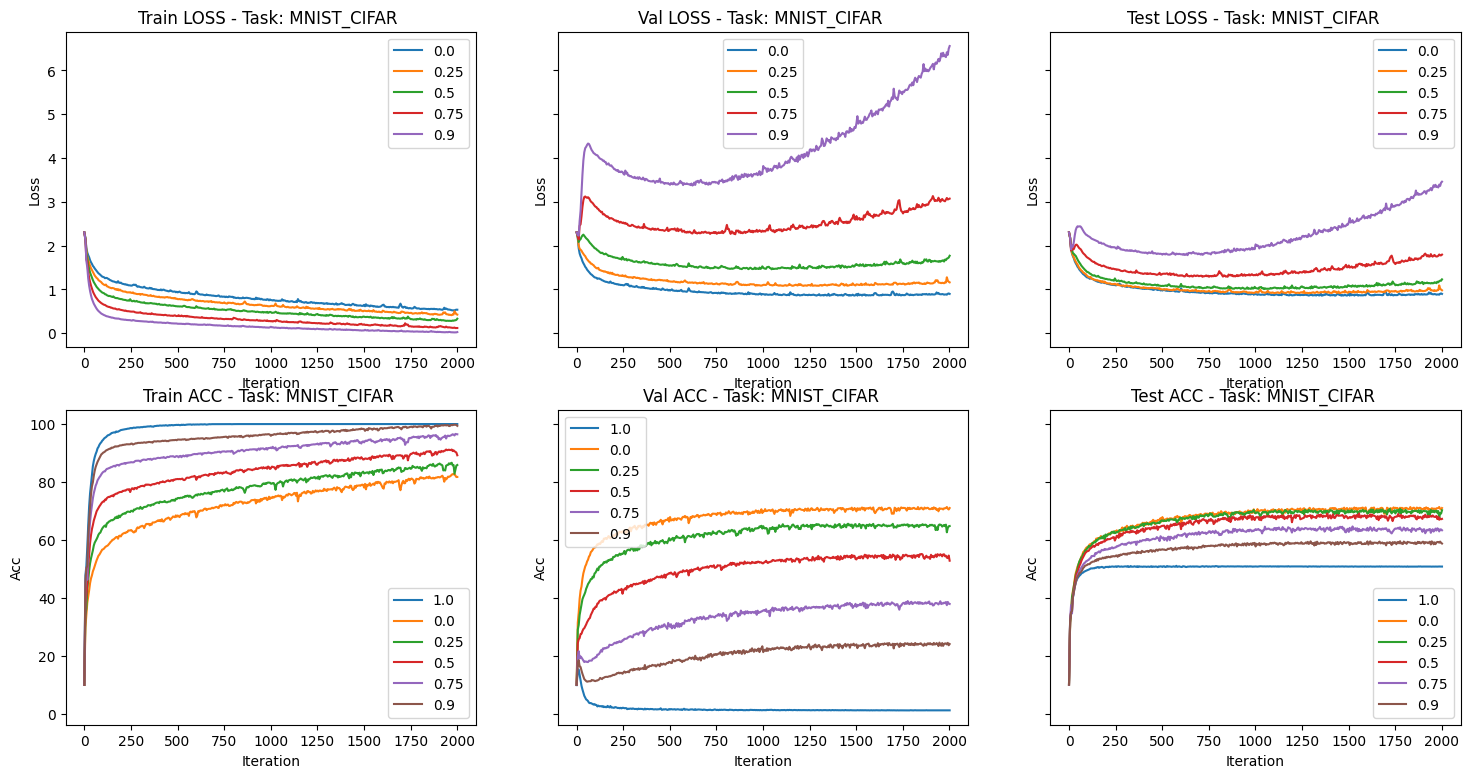

In [46]:
fig, axs = plt.subplots(2, n_splits,figsize=(18, 3*n_splits), constrained_layout=False, sharey="row")

# plot data

for i, m in enumerate(['loss','acc']):
    ylabel = m.capitalize()
    for j, split in enumerate(splits):
        data = all_data[split][m]
        xvals = data[0]
        means = data[1]
        stds = data[2]
        captions = [k for k in data[-1]]

        for x, y, std,c in zip(xvals, means, stds,captions):

            if not(m=="loss" and c == "1.0"):

                axs[i,j].plot(x, y,label=c)
                axs[i,j].fill_between(x, y - std, y + std, alpha=0.2)

        # Add labels and title
        axs[i,j].set_xlabel('Iteration')
        axs[i,j].set_ylabel(ylabel)
        axs[i,j].set_title(f"{split.capitalize()} {m.upper()} - Task: MNIST_CIFAR ")
        axs[i,j].legend()

# Save each subplot as a separate PNG file
save_subplots(axs, "imgs", "mnistcifar_10")


In [38]:
df = create_table(all_data['train']['acc'], all_data['test']['acc']).sort_index()
df.sort_index()
df = df.style.format({'train': '{:,.1f}%'.format,
                      'test': '{:,.1f}%'.format,
                      'delta': '{:,.1f}%'.format,
                      'slowdown': '{:,.1f}%'.format})

display(HTML(df.to_html()))

,train,test,delta,time to 90% - train,time to 90% - test,slowdown
0.0,82.8%,71.4%,11.4%,2000,2000,0.0%
0.25,86.7%,70.8%,15.9%,2000,2000,0.0%
0.5,91.2%,69.1%,22.1%,1765,2000,13.3%
0.75,96.6%,64.7%,31.9%,645,2000,210.1%
0.9,99.8%,59.6%,40.2%,100,2000,"1,900.0%"
1.0,100.0%,51.1%,48.9%,65,2000,"2,976.9%"
